[View in Colaboratory](https://colab.research.google.com/github/christian-rncl/Deep-Learning-SU18/blob/master/projects/cabbage_vs_lettuce_part2.ipynb)

#Google colab setup

Make sure to set runtime to GPU

In [1]:
##Install torch
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
print("torch installed: ", torch.__version__)

torch installed:  0.3.0.post4


In [2]:
 ##Install the fastai library
!pip install fastai

#Lettuce Vs Cabbages

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#import fastai library
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
#check gpu setup
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

Set the path to data and download dataset. Dataset was scraped from google images and stored as  a zip file in my github

In [0]:
#set
PATH = "data/cabbagelettuce/"
sz=224

In [8]:
rm -rf data data.zip && ls -a

.   .cache   datalab   .ipython  lr_plot.png  .torch
..  .config  .forever  .local	 .nv	      .wget-hsts


In [0]:
##comment line below to see LONG output of download and unzip
%%capture 
!mkdir data && wget https://github.com/christian-rncl/Deep-Learning-SU18/raw/master/projects/cabbage_vs_lettuce/data/data.zip && unzip data.zip -d data/cabbagelettuce

## Look at data 

In [10]:
import os
os.listdir(PATH)

['train', 'valid']

In [11]:
os.listdir(f'{PATH}valid')

['lettuce', 'cabbage']

In [12]:
os.listdir(f'{PATH}train')

['lettuce', 'cabbage']

In [13]:
files = os.listdir(f'{PATH}valid/lettuce')[:5]
files

['lettuce.11.jpg',
 'lettuce.30.jpg',
 'lettuce.17.jpg',
 'lettuce.33.jpg',
 'lettuce.0.jpg']

**Note:**
Loading images won't work in google colab without running the code below: <br>
source: https://stackoverflow.com/questions/48547660/attributeerror-module-pil-image-has-no-attribute-register-extensions

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

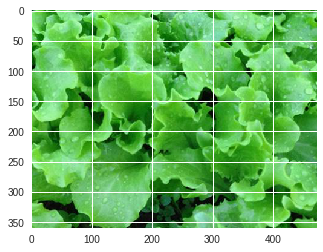

In [15]:
img = plt.imread(f'{PATH}valid/lettuce/{files[0]}')
plt.imshow(img);

In [16]:
img.shape

(360, 473, 3)

In [17]:
img[:4,:4]

array([[[  0,  35,  25],
        [  0,  42,  26],
        [  6,  60,  34],
        [ 29,  91,  52]],

       [[ 93, 142, 121],
        [ 90, 143, 117],
        [ 90, 147, 114],
        [ 95, 161, 115]],

       [[131, 187, 152],
        [130, 188, 148],
        [128, 191, 144],
        [128, 199, 139]],

       [[127, 192, 138],
        [132, 200, 141],
        [140, 212, 146],
        [143, 221, 146]]], dtype=uint8)

##Training the model

First train conv net with the default settings from the lesson1 notebook without any data augmentation

In [18]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


epoch      trn_loss   val_loss   accuracy   
    0      0.873938   0.480521   0.753086  
    1      0.681118   0.376229   0.851852  



[array([0.37623]), 0.8518518540594313]

## Analyzing initial results

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [19]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
# from here we know that 'cabbage' is label 0 and 'lettuce' is label 1.
data.classes

['cabbage', 'lettuce']

In [21]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(81, 2)

In [22]:
log_preds[:10]

array([[-0.13424, -2.07448],
       [-0.11734, -2.20079],
       [-0.06706, -2.73552],
       [-0.06782, -2.72455],
       [-0.11885, -2.18873],
       [-0.30305, -1.34155],
       [-0.42012, -1.06993],
       [-0.0725 , -2.66019],
       [-0.02618, -3.6557 ],
       [-0.01279, -4.36574]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)


In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


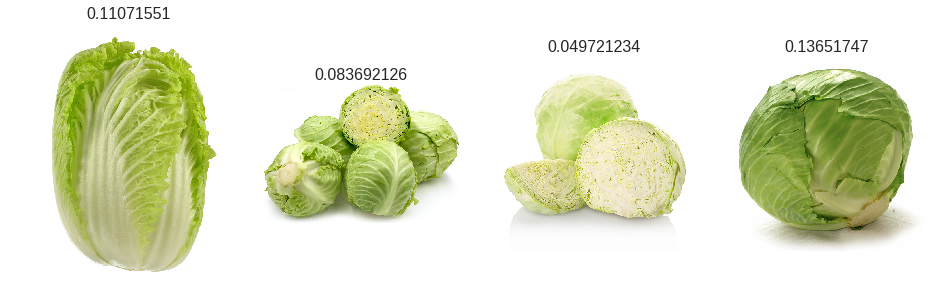

In [27]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


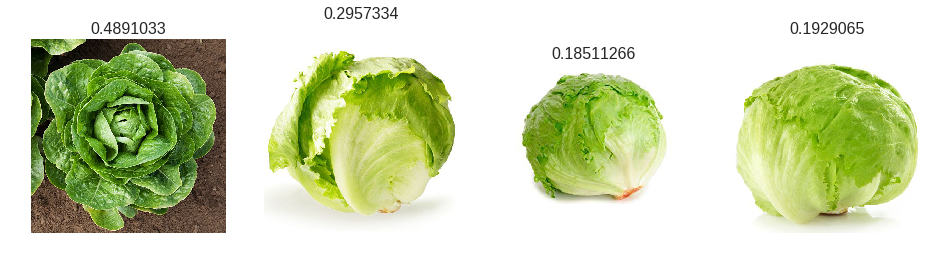

In [28]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cabbages


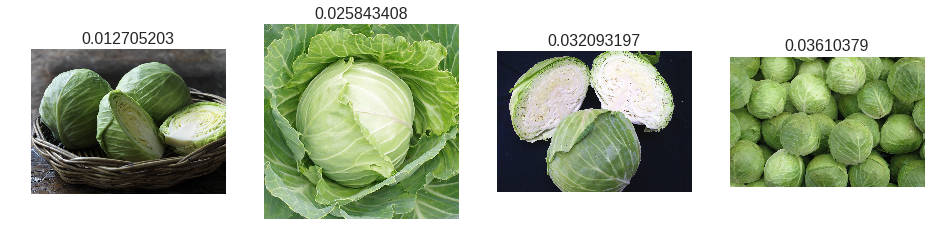

In [30]:
plot_val_with_title(most_by_correct(0, True), "Most correct cabbages")

Most correct lettuce


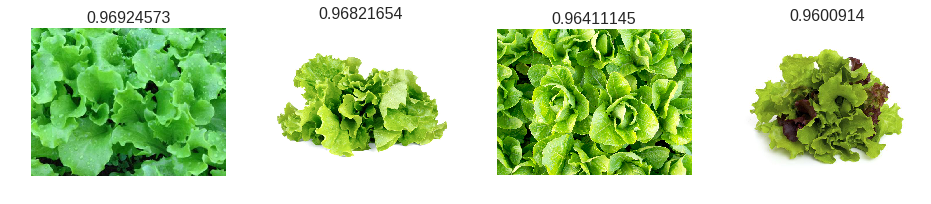

In [31]:
plot_val_with_title(most_by_correct(1, True), "Most correct lettuce")


In [32]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cabbage")

Most incorrect cabbage


Most incorrect lettuce


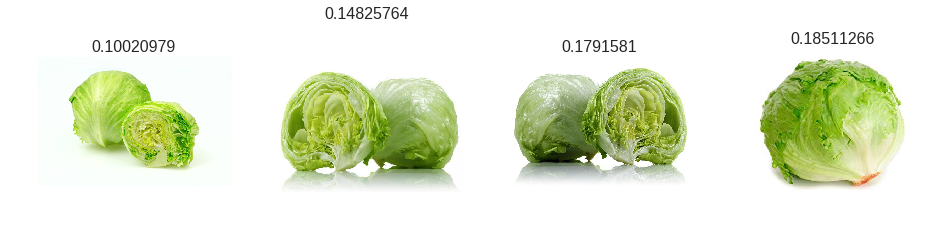

In [33]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect lettuce")

Most uncertain predictions


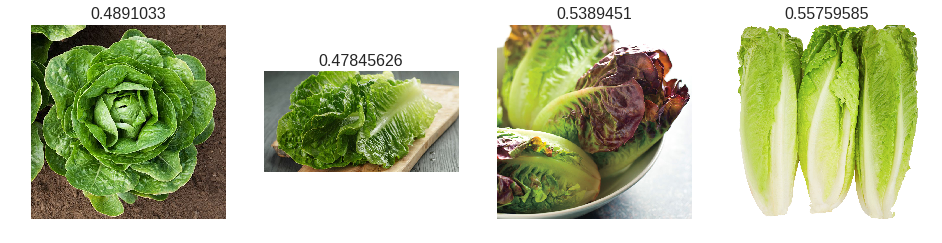

In [34]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

##Using techniques to choose *initial* learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [36]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy   
    0      0.914072   3.352609   0.666667  



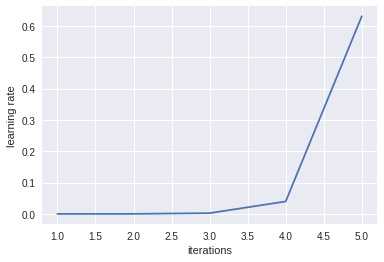

In [37]:
learn.sched.plot_lr()

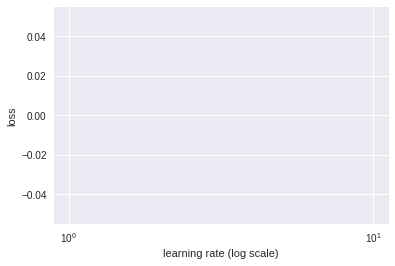

In [38]:
learn.sched.plot()

The blank chart is an issue and could probably be solved with more data. For this exercise we are using only around 300 images for each category. 800-1000 images were used for the fastai dogs vs cats exercise

##Data Augmentation

Transform current data in ways that doesn't affect its interpretation (rotating and zooming). This creates more data in the training set and helps optimize our model. 

In [0]:
# from pprint import pprint
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# pprint(tfms)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

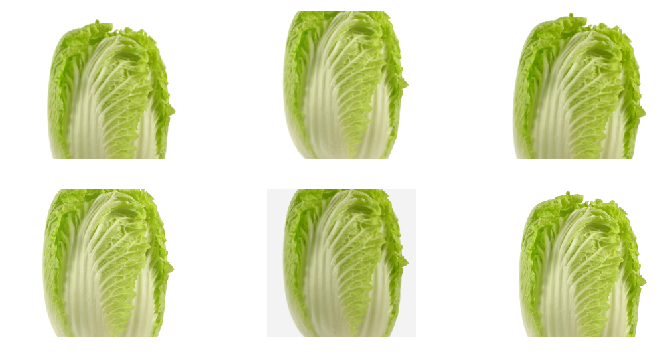

In [42]:
plots(ims, rows=2)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [44]:
learn.fit(.03, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.815657   0.501709   0.790123  
    1      0.531515   0.421279   0.864198  



[array([0.42128]), 0.8641975338076368]

Here the re-training with data augmentation didn't seem to affect the accuracy. Why? It's because we're using a model with pre-computed activations. This means that the model has - for each image - precomputed the probability of features. Thus, these transformations won't help. 

In [0]:
learn.precompute=False

The solution for this is simply not to precompute activations.

**Why precompute activations at all?:**
The purpose of precomputing activations was to make the model faster. Notice how the initial call to learn.fit() took longer than subsequent calls. This is because the activations were being pre-computed.

In [46]:
learn.fit(.03, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.307519   0.351773   0.888889  
    1      0.30804    0.224309   0.901235  



[array([0.22431]), 0.901234570108814]

##SGDR - Stochastic Gradient Descent with Restarts

Another trick to make the accuracy much better SGDR. SGDR is a variant of learning rate annealing:

the cycle_len=1 option enables SGDR.

In [47]:
learn.fit(.03, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.247358   0.219996   0.901235  
    1      0.263335   0.251797   0.91358   



[array([0.2518]), 0.9135802491211596]

**Annealing?** 
Annealing refers to slowing down the learning rate as we get closer to the optimal weights for the model

**Cosine Annealing**
Is a type of annealing schedule which follows half a cosine wave patttern. 


**SGDR :** 
Stochastic Gradient Descent with Restarts. The *"SGD"* part is pretty familiar. Simply put, the gradient of the loss function is used to try to find its minima. The issue with this method is that it is vulnerable to finding a local minima instead of a global one. 

"Restarts" solve this problem of SGD by making the model "jump" to a different space by *"restarting"* the annealing (making the learning rate jump back up to the initial learning rate provided) if it's currently finding a minima for a "spikey" weight space that doesn't generalize well.

It cycles through annealing schedules to enable this "jumping" behavior

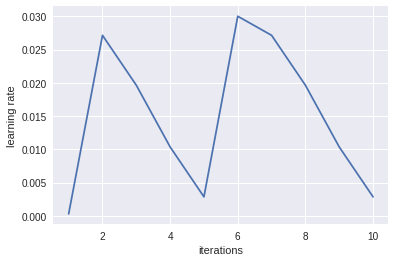

In [48]:
learn.sched.plot_lr()
#these were supposed to look like cosine waves

We've come a long way from 80% accuracy to 93%. It's a good idea to "save" the model so it wouldn't be necessary to train them again:

In [0]:
learn.save("cablet_lastlayer")

In [0]:
learn.load("cablet_lastlayer")

## Fine tuning and diferential learning rate annealing

###Unfreezing
We have been using a convolutional neural network pretrained on the imagenet dataset. This means that we've only been training the last layer, while the earlier layers are **"frozen:"** not updated.

This means that the convolutional filters were created from the imagenet dataset. Since our dataset is very specific, and not like images from imagenet, we should probably train these earlier layers as well. This can be done by **unfreezing** the learner object



In [0]:
learn.unfreeze()

###Differential Learning Rates

The earlier layers of the CNN are for detecting basic convolutions: edges, shadows etc.. thus not too much training should be necessary for those layers. The middle and last layers, on the other hand, are more specific and needs more training in the new dataset.

For this reason we will be using different learning rates for each set of layers.This is referred to as differential learning rates.

In [0]:
lr = np.array([3e-4, 3e-3, 3e-2])

In [53]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.382967   0.220182   0.925926  
    1      0.295172   0.16464    0.91358   
    2      0.256079   0.140587   0.938272  
    3      0.220765   0.101618   0.962963  
    4      0.187347   0.082981   0.962963  
    5      0.1614     0.072527   0.962963  
    6      0.140794   0.073395   0.962963  



[array([0.0734]), 0.9629629629629629]

Above we used a new hyper-parameter: **cycle_mult.**
The chart below illustrates well what it does.

It makes the number of epochs increase per cycle. Concretely, the number of epochs per cycle n * cycle_mult where n is the i in the i'th cycle (1st cycle, n = 1, 2nd cycle, n = 2) etc...


**But why?**
Increasing the number of epochs for the later cycles gives the model more time to really hit the minima instead of popping out prematurely.

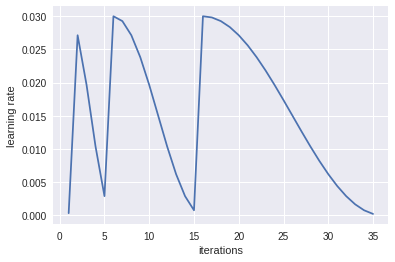

In [54]:
learn.sched.plot_lr()

In [0]:
learn.save('cablet_all')

In [0]:
learn.load('cablet_all')

### Test Time Augmentation

Another trick we have is test time augmentation. This refers to using augmented data during testing. When using TTA, a number (4 for our case) of randomly augmented version an image is tested and a score is averaged. 

This makes it so that if the object of interest is not in the original frame, there's a chance to recognize that object in one of the augmented versions of the image.

In [57]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [58]:
accuracy_np(probs, y)

0.9753086419753086

##Analyzing results

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[39  1]
 [ 1 40]]


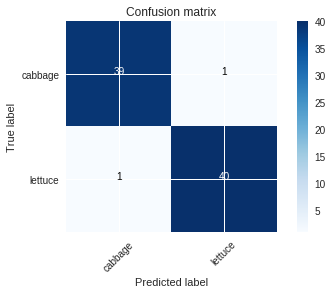

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

The classic confusion matrix: 39 correct cabbages, 1 cabbage incorrectly predicted as a lettuce etc...

###Looking at the pictures again

Most incorrect cabbages


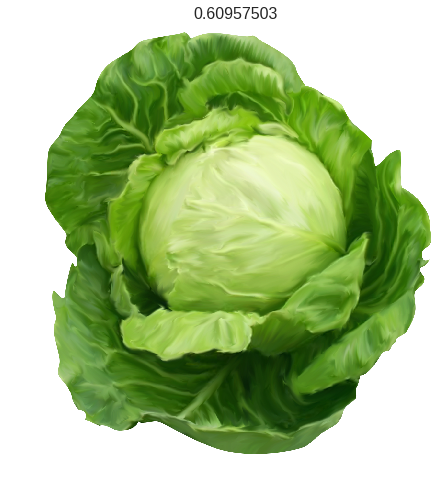

In [61]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cabbages")

Most incorrect Lettuce


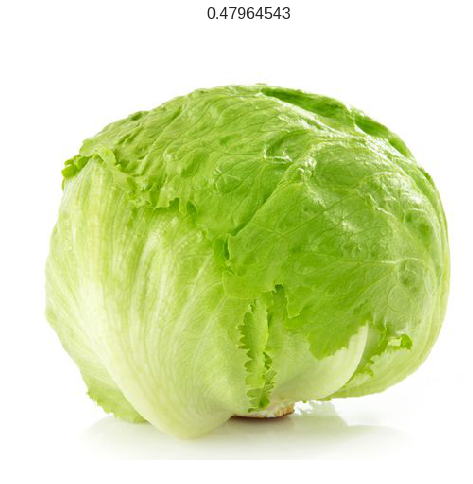

In [62]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Lettuce")

These results are pretty good since we only have about 80 images in our validation set!